# midinet_doubleの前処理
2小節1セットにしたmidinet  

以下のような`midinet_double`データセットを作成
- 全体的なこと
    - resolutionを12にして音符の切れ目を一番後ろ空白にする
    - スケール外の音が生成されてしまうのでトランスポーズによる水増しを行わない
    - メロディが鳴っていない部分は削除
- メロディのこと
    - MIDI音程を36～99(99を含む, C2~D#7)の64ピッチ以内にシフトし， ピッチ方向は64入力のモデルで学習
    - 提示されているkeyはあてにならないので，estimated_keyに合わせてトランスポーズする
        - なるべく36~99の64ピッチ以内に入るようトランスポーズ
- コードのこと
    - few-hot vectorを使用 -> 12で割って得られたピッチをそのまま使う. 展開形などにも対応できる
    - 1小節に複数のコードがあることを表現するコードベクトルにする -> 拍ごとにコードチェックし，12×4×2=96次元のベクトルにする
    - prevが変わってしまうのでコードは削らない

以上から，得られるデータは次のようなものになる  
- melody: (obtained_bars, 96, 64)
- prev: (obtained_bars, 96, 64)
- condition: (obtained_bars, 96)

必要なProcessorは以下になる  
- global_melody_processors
    - Binarize()
    - DownResolution(12, fill_mode=False)
        - fill_mode: Trueのとき，ステップの最初に音符があれば埋めるが，Falseなら空白にする
- melody_processors
    - TransposeMelody(key=0, standard_pitch_range=[36, 99])
    - ShiftInRange(bottom=36, top=99)
    - Trim(bottom=36, top=99)
    - SeparateTrackIntoBars(bars=2)
- prev_processors
    - GetPrevBars()
- chord_processors
    - SeparateTrackIntoChordVectors(steps=4)
    - TransposeChordVectors(shift=transpose_melody.shift
- RemoveSparceBars(threshold=0.3)

In [1]:
import os, ipdb, pickle
import numpy as np
import pandas as pd
from pypianoroll import Multitrack, Track
from processors import PypianorollProcessor, Processor
from utils import grid_plot, Timer
from multiprocessing import Pool, cpu_count

print(f"{cpu_count()} cpus are available.")

import matplotlib.pyplot as plt
%matplotlib inline

32 cpus are available.


In [2]:
base_dir = "../datasets/theorytab"
input_dir = f"{base_dir}/pianoroll"
input_csv = f"{base_dir}/theorytab.csv"
output_dir = f"{base_dir}/midinet"

In [3]:
df_org = pd.read_csv(input_csv)
print(df_org.shape)
df_org.head()

(39614, 22)


,Unnamed: 0,path,artist,song,section,nokey,key_signature,estimated_key_signature,in_scale_rate,estimated_in_scale_rate,...,lowest_melody,highest_chord,lowest_chord,bpm,time_signature,beats,bars,time,has_melody_track,has_chord_track
0,0,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,False,Bb Major,Bb Major,0.88278,0.88278,...,65.0,63.0,43.0,146,4/4,48,12,19.73,True,True
1,1,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,True,Bb Major,C Major,0.74186,0.88278,...,55.0,60.0,43.0,146,4/4,48,12,19.73,True,True
2,2,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",False,D Major,D Major,1.00000,1.00000,...,57.0,57.0,45.0,120,4/4,32,8,16.00,True,True
3,3,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",True,D Major,C Major,0.74297,1.00000,...,55.0,55.0,43.0,120,4/4,32,8,16.00,True,True
4,4,q/queen-and-bowie/under-pressure/intro_nokey.mid,queen-and-bowie,under-pressure,intro,True,D Major,C Major,0.65812,1.00000,...,55.0,59.0,48.0,240,4/4,32,8,8.00,True,True


In [4]:
df = df_org
df = df[(df["nokey"] == False) & (df["time_signature"] == "4/4")]
df = df[df["has_melody_track"] & df["has_chord_track"]]
df = df.reset_index()
print(df.shape)
df.head()

(16386, 23)


,index,Unnamed: 0,path,artist,song,section,nokey,key_signature,estimated_key_signature,in_scale_rate,...,lowest_melody,highest_chord,lowest_chord,bpm,time_signature,beats,bars,time,has_melody_track,has_chord_track
0,0,0,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,False,Bb Major,Bb Major,0.88278,...,65.0,63.0,43.0,146,4/4,48,12,19.73,True,True
1,2,2,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",False,D Major,D Major,1.00000,...,57.0,57.0,45.0,120,4/4,32,8,16.00,True,True
2,5,5,q/queen-and-bowie/under-pressure/intro_key.mid,queen-and-bowie,under-pressure,intro,False,D Major,D Major,1.00000,...,57.0,61.0,50.0,240,4/4,32,8,8.00,True,True
3,8,8,q/queen/the-show-must-go-on/intro-and-verse_ke...,queen,the-show-must-go-on,"intro,verse",False,B Major,B minor,0.64627,...,70.0,59.0,42.0,83,4/4,57,14,40.48,True,True
4,10,10,q/queen/the-show-must-go-on/bridge_key.mid,queen,the-show-must-go-on,bridge,False,C Major,A minor,1.00000,...,57.0,60.0,43.0,84,4/4,24,6,17.14,True,True


In [5]:
df.loc[0]['path']

'q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid'

In [5]:
def get_sample(index=0, get_series=False):
    path = df.loc[index]['path']
    ppr = Multitrack(os.path.join(input_dir, path))
    print(f"sample {index} picked from {path}")
    if get_series:
        return ppr, df.loc[index]
    else:
        return ppr

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid


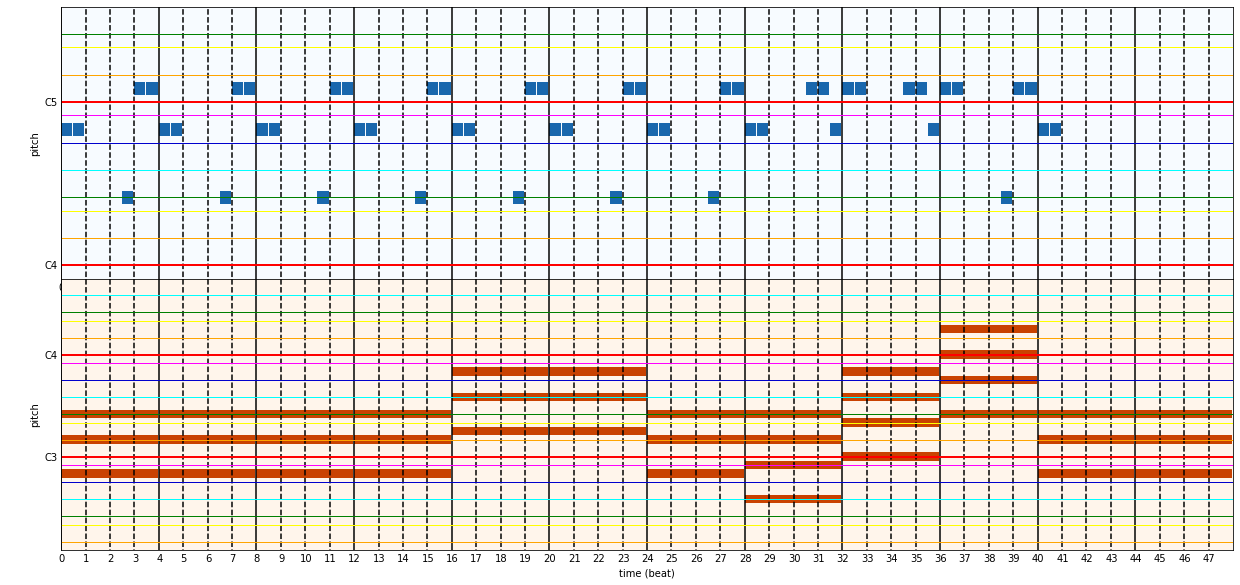

In [6]:
grid_plot(get_sample())

### ベロシティは無視し，2値化する

In [6]:
class Binarize(Processor):
    def __call__(self, ppr, track):
        ppr.binarize()
        track.binarize()
        return ppr, track

In [8]:
ppr = get_sample()
binarize = Binarize()

with Timer():
    ppr, track = binarize(ppr, ppr.tracks[0])
print(ppr.is_binarized(), track.is_binarized())

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid
Timer: 0.000781
True True


### resolutionを下げる
fill_mode機能を組み入れる

In [7]:
class DownBeatResolution(Processor):
    """
    全てのトラックのresolutionを下げるので注意
    """
    def __init__(self, resolution_to, resolution_from=None, fill_mode=True):
        self.res_to = resolution_to
        self.res_from = resolution_from
        self.fill_mode = fill_mode
        
        if self.res_from is not None and self.res_to >= self.res_from:
            raise ValueError(f"Resolution_to (given: {self.res_to}) must be smaller than resolution_from (given: {self.res_from}).")

    def down_resolution(self, nproll, step_width):
        result = nproll[::step_width]
        if not self.fill_mode:
            note_existence = nproll.astype(bool)
            for s in range(1, step_width):
                result *= note_existence[s::step_width]
        return result
    
    def __call__(self, ppr, track):
        if self.res_from is None:
            if self.res_to >= ppr.beat_resolution:
                raise ValueError(f"Target resolution ({self.res_to}) must be smaller than the original resolution ({ppr.beat_resolution})")
            step_width = ppr.beat_resolution // self.res_to
        else:
            step_width = self.res_from // self.res_to
            
        ppr.beat_resolution = self.res_to
        ppr.downbeat = ppr.downbeat[::step_width]
        
        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is track: track_is_in_ppr = True # isは参照の等価チェック
            ppr_track.pianoroll = self.down_resolution(ppr_track.pianoroll, step_width)
        
        if not track_is_in_ppr:
            track.pianoroll = self.down_resolution(track.pianoroll, step_width)
            
        return ppr, track

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid
before -> resolution: 24, active length: 1151
Timer: 0.000674
after: -> resolution: 12, active length: 575


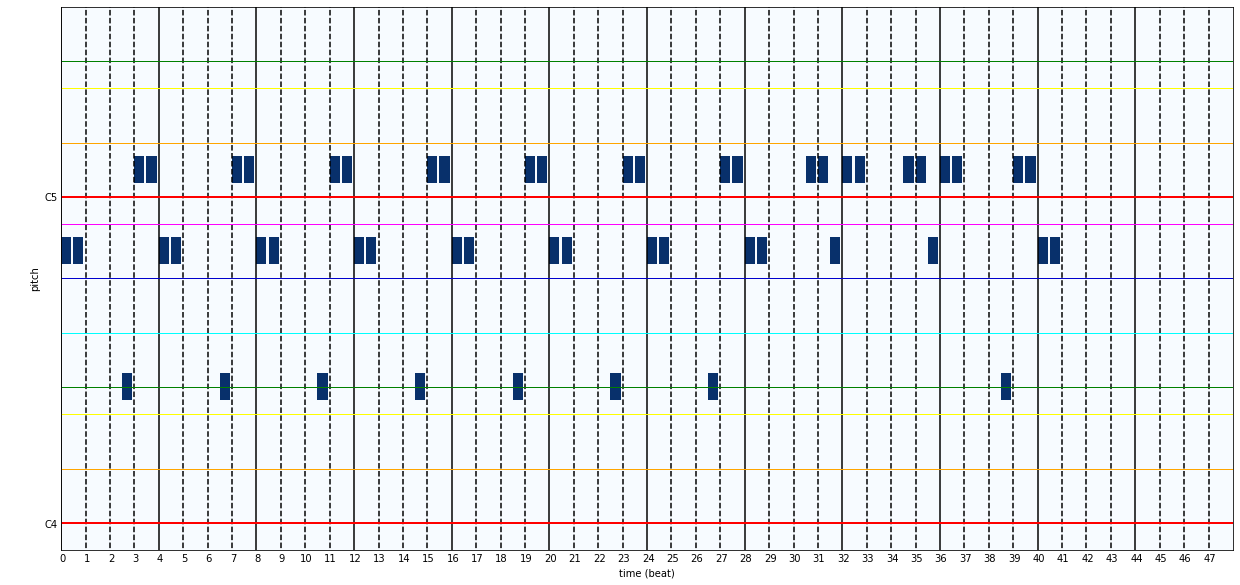

In [10]:
ppr = get_sample()
down_resolution = DownBeatResolution(12, fill_mode=False)
ppr, track = binarize(ppr, ppr.tracks[0])

print(f"before -> resolution: {ppr.beat_resolution}, active length: {ppr.get_active_length()}")
with Timer():
    ppr, track = down_resolution(ppr, ppr.tracks[0])
print(f"after: -> resolution: {ppr.beat_resolution}, active length: {ppr.get_active_length()}")
grid_plot(ppr.tracks[0], beat_resolution=ppr.beat_resolution)

### メロディをKey=Cにトランスポーズする
estimated_keyに基づくことにする．  
minorならAへ，MajorならCへトランスポーズする

In [8]:
sharp_key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
flat_key_names  = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
key_names_dict = {}
for i, (name_s, name_f) in enumerate(zip(sharp_key_names, flat_key_names)):
    key_names_dict[name_s], key_names_dict[name_f] = i, i

class TransposeMelody(Processor):
    """
    to_keyはメジャースケールにおける主音
    例えば to_key=0 のとき, C minor を渡せば A minor へトランスポーズする
    変更元のkeyを後で変更できるのでインスタンスを再生成しなくていい
    変換後シフト量が取得できるので，別のトラックのシフトに再利用できる
    """
    def __init__(self, from_key_name="C Major", to_key=0, standard_pitch_range=[36,99]):
        self.set_key(from_key_name, to_key)
        self.std_bottom, self.std_top = standard_pitch_range
        self.shift = None
    
    def set_key(self, key_name, to_key=0):
        key_name, mode = key_name.split(' ')
        self.from_key = key_names_dict[key_name]
        self.to_key = (to_key - 3) % 12 if mode == "minor" else to_key
    
    def get_active_range(self, nproll):
        pitches = np.where(nproll)[1]
        return np.min(pitches), np.max(pitches)
        
    def __call__(self, ppr, track):
        # standatd_pitch_rangeで移動後のlowestとhighestを囲った時，マージンの大きい方へトランスポーズする
        nproll = track.pianoroll if isinstance(track, Track) else track
        lowest, highest = self.get_active_range(nproll)
        shift_down      = (self.from_key - self.to_key) % 12
        shift_up        = (self.to_key - self.from_key) % 12
        margin_bottom   = (lowest - shift_down) - self.std_bottom
        margin_top      = self.std_top - (highest + shift_up)
        shift           = shift_up if margin_top > margin_bottom else -shift_down
        self.shift      = shift
        
        if shift != 0:
            transposed = np.zeros_like(nproll)
            transposed[:, lowest+shift:highest+shift+1] = nproll[:, lowest:highest+1]
            track.pianoroll = transposed
        
        return ppr, track

sample 100 picked from c/capcom/mega-man-9---tornado-man-stage/intro_key.mid
Timer: 0.000875
original key name: E minor
shifts: -7


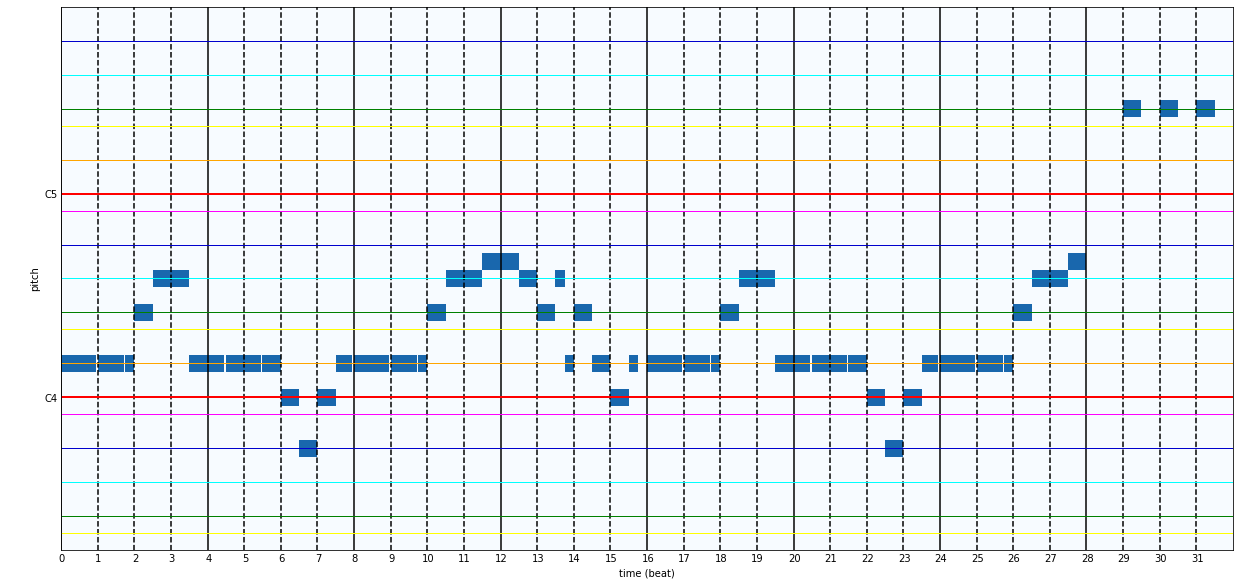

In [12]:
ppr, sr = get_sample(100, get_series=True)
org_key = sr['estimated_key_signature']
transpose_melody = TransposeMelody(org_key)

with Timer():
    ppr, track = transpose_melody(ppr, ppr.tracks[0])

print("original key name:", org_key)
print("shifts:", transpose_melody.shift)
grid_plot(ppr.tracks[0])

### メロディをC3~D#7の中にシフト
一応注意: pretty_midiのpitch=0はC-1でpypianorollのplotのpitch=0はC-2だった

In [9]:
class ShiftInRange(Processor):
    def __init__(self, bottom, top):
        if bottom < 0 or top > 127:
            raise ValueError("Pitch range must be in [0, 127].")
        if top - bottom < 12:
            raise ValueError("Pitch range must be larger than 12 pitches.")
        self.bottom, self.top = bottom, top
    
    def __call__(self, ppr, track):
        nproll = track.pianoroll if isinstance(track, Track) else track
        bottom, top = self.bottom, self.top
                
        lower_step, lower_pitches = np.where(nproll[:, :bottom])
        new_lower_pitches = lower_pitches - (lower_pitches - bottom) // 12 * 12
        nproll[lower_step, new_lower_pitches] = nproll[lower_step, lower_pitches]
        nproll[lower_step, lower_pitches] = 0
        
        higher_step, higher_pitches_from_top = np.where(nproll[:, top+1:])
        higher_pitches = higher_pitches_from_top + (top + 1)
        new_higher_pitches = higher_pitches - (higher_pitches_from_top + 13) // 12 * 12
        nproll[higher_step, new_higher_pitches] = nproll[higher_step, higher_pitches]
        nproll[higher_step, higher_pitches] = 0
        
        return ppr, track

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid
start global melody processing
Timer: 0.000405


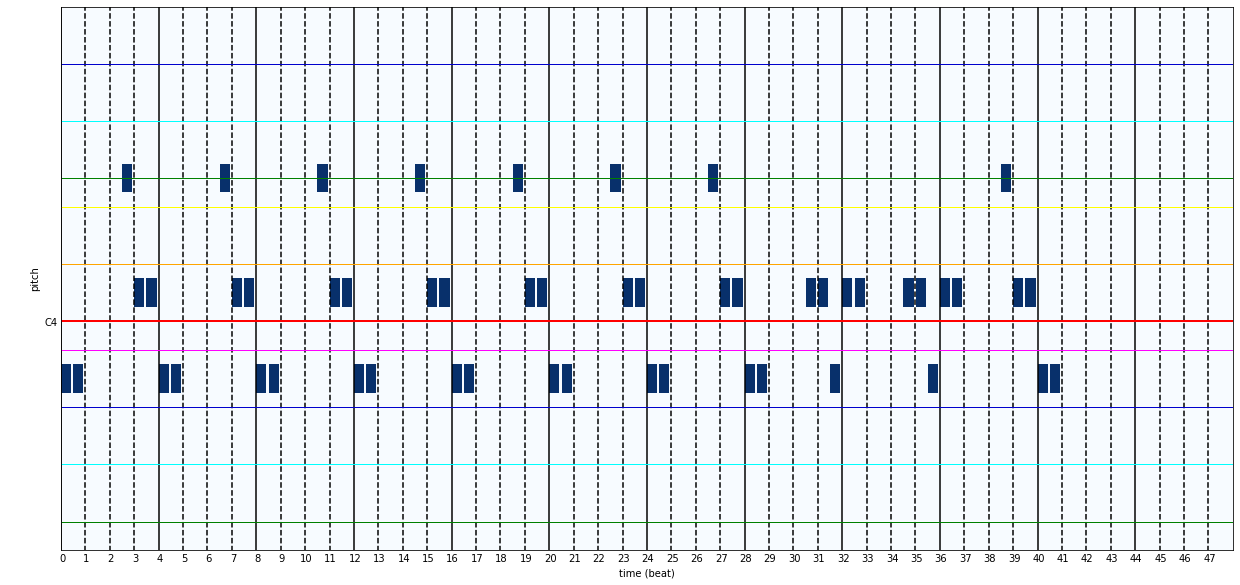

In [14]:
ppr = get_sample()
# bottom, top = 36, 99 # C3 ~ D#7
# bottom, top = 65, 80 # lower to higher
bottom, top = 56, 69 # higer to lower
shift_in_range = ShiftInRange(bottom, top)
melody = ppr.tracks[0]

print("start global melody processing")
for p in [binarize, down_resolution]:
    ppr, melody = p(ppr, melody)

with Timer():
    ppr, melody = shift_in_range(ppr, melody)

grid_plot(melody, beat_resolution=ppr.beat_resolution)

### ピッチのトリム
ShiftInRangeをしたところで，その外側の領域を削除してサイズを変えてしまう

In [10]:
class TrimInRange(Processor):
    def __init__(self, bottom, top):
        if bottom < 0 or top > 127:
            raise ValueError("Pitch range must be in [0, 127].")
        if top - bottom < 12:
            raise ValueError("Pitch range must be larger than 12 pitches.")
        self.bottom, self.top = bottom, top
    
    def __call__(self, ppr, track):
        if isinstance(track, Track):
            track.pianoroll = track.pianoroll[:, self.bottom:self.top+1]
        else:
            track = track[:, self.bottom:self.top+1]
            
        return ppr, track

In [16]:
ppr = get_sample()
trim = TrimInRange(36, 99)

with Timer():
    ppr, track = trim(ppr, ppr.tracks[0])

print(ppr.tracks[0].pianoroll.shape)
print(track.pianoroll.shape)

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid
Timer: 0.000010
(1152, 64)
(1152, 64)


### メロディを複数の小節ブロックごとに分割
切れ端になってしまったらゼロフィルする

In [11]:
class SeparateMelodyIntoBars(Processor):
    def __init__(self, bars=1, beats_in_bar=4):
        self.bars = bars
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        nproll = track.pianoroll if isinstance(track, Track) else track
        
        song_len = len(ppr.downbeat)
        bars_step_num = self.bars * ppr.beat_resolution * self.beats_in_bar
        bars_num = int(np.ceil(song_len / bars_step_num))
        
        filled_roll = np.zeros([bars_num * bars_step_num, nproll.shape[1]], dtype=int)
        filled_roll[:len(nproll)] = nproll
        bars = filled_roll[:bars_num*bars_step_num].reshape(bars_num, bars_step_num, -1)
                
        return ppr, bars

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid
bar resolution: 96
Timer: 0.000918
(6, 192, 128)


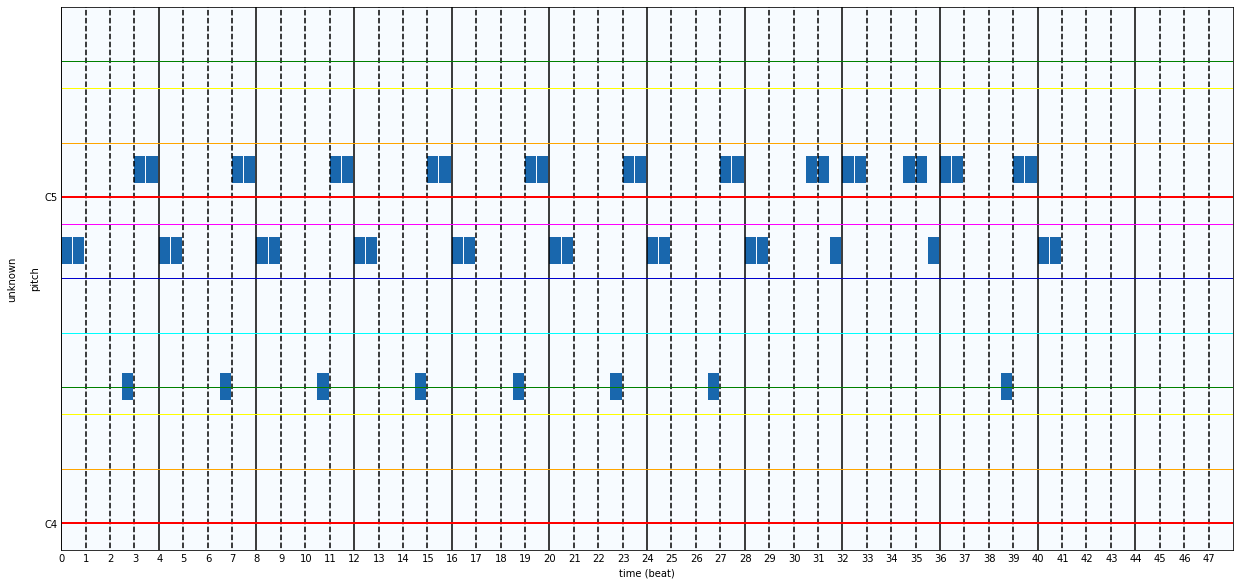

In [49]:
ppr = get_sample()
separate_melody = SeparateMelodyIntoBars(bars=2)

print("bar resolution:", ppr.beat_resolution * 4)
with Timer():
    ppr, bars = separate_melody(ppr, ppr.tracks[0])
print(bars.shape)
grid_plot(Track(pianoroll=np.vstack(bars)), beat_resolution=ppr.beat_resolution)

### 前小節データを得る
最初の小節のprevを最後の小節にするかを選択可能にする

In [12]:
class GetPrevBars(Processor):
    def __init__(self, first_prev_is_last=False):
        self.first_prev_is_last = first_prev_is_last
    
    def __call__(self, ppr, bars):
        if bars.ndim != 3:
            raise ValueError("ndim of bars must be 3")        
        prev_bars = np.zeros_like(bars)
        prev_bars[1:] = bars[:-1]
        
        if self.first_prev_is_last:
            prev_bars[0] = bars[-1]
        
        return ppr, prev_bars

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid
(6, 192, 128)
Timer: 0.005748
(6, 192, 128)


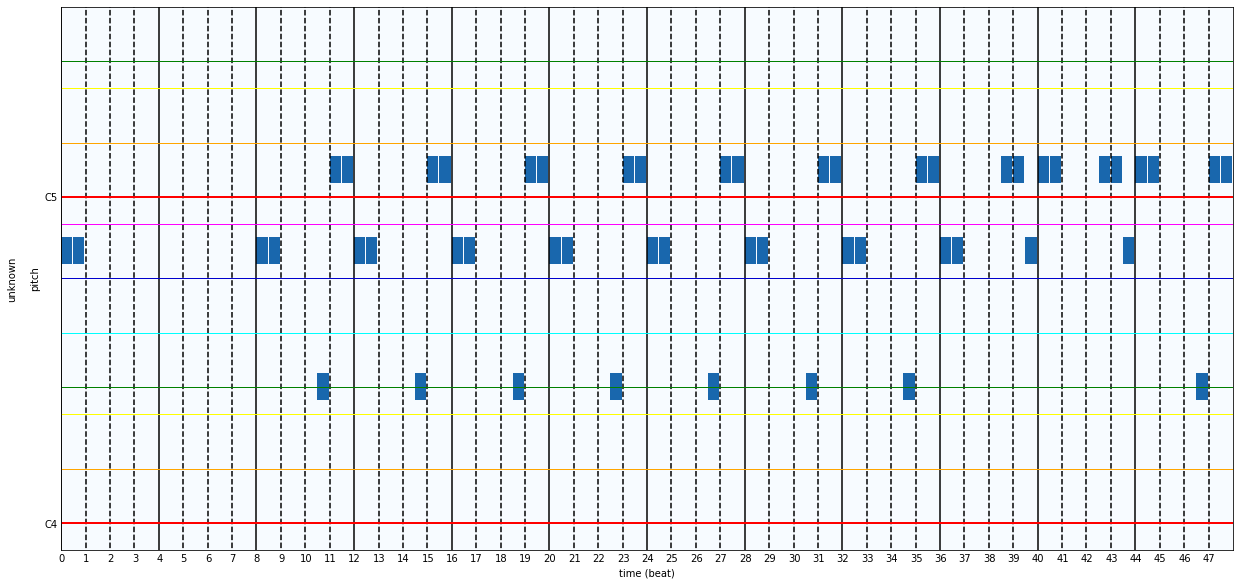

In [63]:
ppr = get_sample()
separate_melody = SeparateMelodyIntoBars(bars=2)
get_prev_bars = GetPrevBars(first_prev_is_last=True)
melody = ppr.tracks[0]

processors = [binarize, down_resolution, trim, separate_melody]
processors = [separate_melody]

for p in processors:
    ppr, melody = p(ppr, melody)

print(melody.shape)
with Timer():
    ppr, prev_bars = get_prev_bars(ppr, melody)
print(prev_bars.shape)

grid_plot(Track(pianoroll=np.vstack(prev_bars)), beat_resolution=ppr.beat_resolution)

### コードベクトルを得る
与えられたサンプリング回数で小節を等分した箇所のコードの構成音を12音階で取得し，1次元のベクトルとして連結して返す  
こちらにも小節数を引数として与える

In [13]:
class SeparateTrackIntoChordVectors(Processor):
    def __init__(self, bars=1, samples_in_bar=4, beats_in_bar=4):
        self.bars = bars
        self.samples_in_bar = samples_in_bar
        self.samples_in_bars = samples_in_bar * bars
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        nproll = track.pianoroll if isinstance(track, Track) else track
        song_len = len(ppr.downbeat)
        bars_step_num = self.bars * ppr.beat_resolution * self.beats_in_bar
        bars_num = int(np.ceil(song_len / bars_step_num))
        sampling_width = bars_step_num // self.samples_in_bars
        
        step, pitch = np.where(nproll[:song_len:sampling_width])
        chord_vecs = np.zeros([bars_num*self.samples_in_bars, 12])
        chord_vecs[step, pitch % 12] = 1
        chord_vecs = chord_vecs.reshape(bars_num, 12*self.samples_in_bars)
        
        return ppr, chord_vecs

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid
Timer: 0.000117
(6, 96)
[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]]

[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]]

[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 

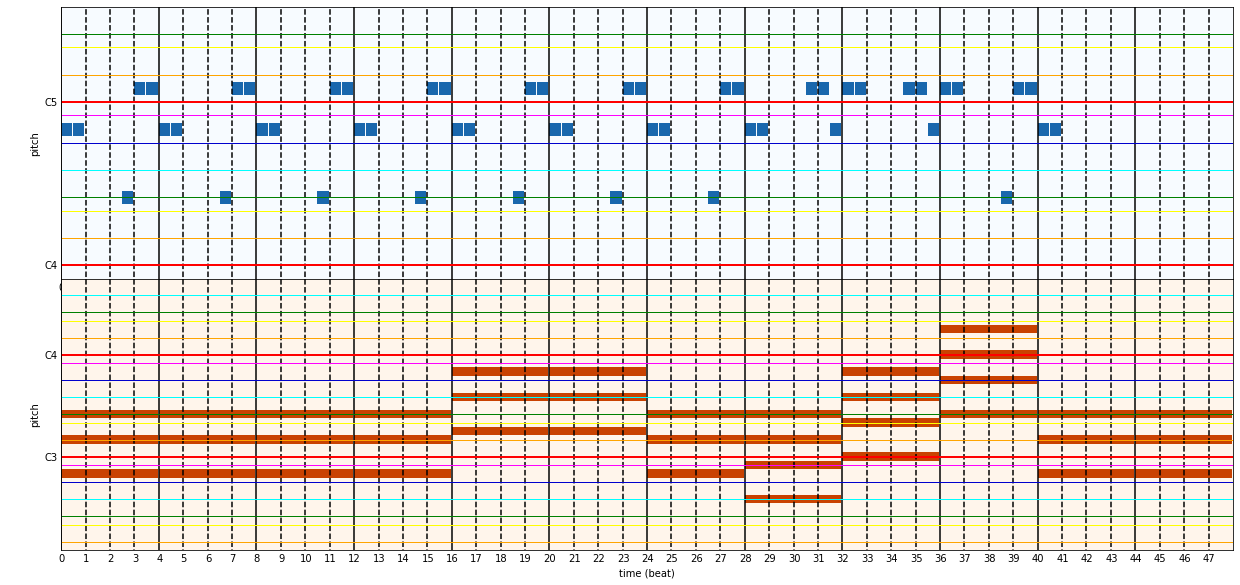

In [71]:
ppr = get_sample()

bars = 2
separate_chord = SeparateTrackIntoChordVectors(bars=bars)

with Timer():
    ppr, chords = separate_chord(ppr, ppr.tracks[1])
print(chords.shape)
for chord in chords[:4]:
    print([[1,0,1,0,1,1,0,1,0,1,0,1]])
    print(chord.reshape(4*bars, -1))
    print()

grid_plot(ppr)

### コードをKey=Cにトランスポーズする
TransposeMelodyのシフトを受け取ることでトランスポーズする

In [14]:
class TransposeChordVectors(Processor):
    def __init__(self, shift=0):
        self.shift = shift
    
    def set_shift(self, shift):
        self.shift = shift
            
    def __call__(self, ppr, chord_vecs):
        if self.shift != 0:
            org_shape = chord_vecs.shape
            chord_vecs = chord_vecs.reshape(-1, 12)
            step, pitch = np.where(chord_vecs)
            pitch = (pitch + self.shift) % 12
            chord_vecs = np.zeros_like(chord_vecs)
            chord_vecs[step, pitch] = 1
            chord_vecs = chord_vecs.reshape(*org_shape)
        return ppr, chord_vecs

sample 100 picked from c/capcom/mega-man-9---tornado-man-stage/intro_key.mid
original key name: E minor
shifts: -7
(4, 96)
[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]]

[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]
[[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]]

[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0

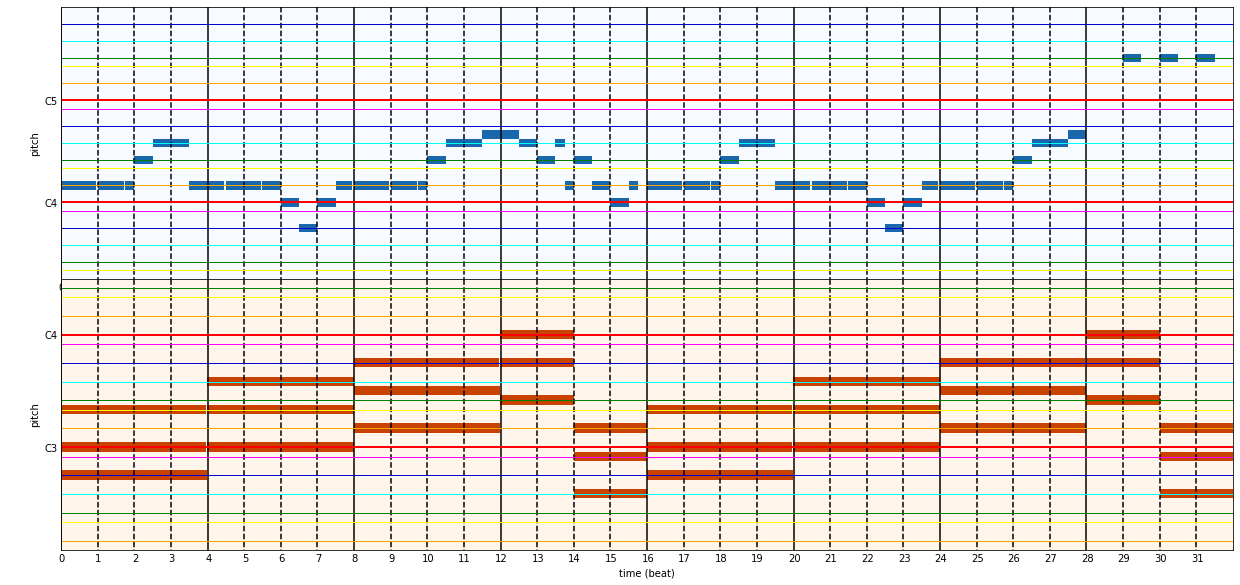

In [74]:
ppr, sr = get_sample(100, get_series=True)
org_key = sr['estimated_key_signature']
transpose_melody = TransposeMelody(org_key)
transpose_chord = TransposeChordVectors(org_key)

ppr, melody = transpose_melody(ppr, ppr.tracks[0])

grid_plot(ppr)

transpose_chord.set_shift(transpose_melody.shift)
ppr, chords = transpose_chord(*separate_chord(ppr, ppr.tracks[1]))
    
print("original key name:", org_key)
print("shifts:", transpose_chord.shift)
print(chords.shape)
for chord in chords[:4]:
    print([[1,0,1,0,1,1,0,1,0,1,0,1]])
    print(chord.reshape(4*bars, -1))
    print()

### メロディがあまり鳴っていない小節ブロックを削除する
melody, prev, chordsを受け取り，メロディがあまり鳴っていない小節を削除して返す

In [15]:
class RemoveSparseBars(Processor):
    def __init__(self, threshold):
        self.threshold = threshold
    
    def __call__(self, melody, prev, chords):
        melody = melody.astype(bool)
        bar_res = melody.shape[1]
        on_note_step_rate = np.sum(np.sum(melody, axis=-1), axis=-1) / bar_res
        sparse_bars = np.where(on_note_step_rate < self.threshold)[0]
        return [np.delete(item, sparse_bars, axis=0) for item in [melody, prev, chords]]

### 単独処理テスト
barを4にしたらlong

In [16]:
def get_track(melody_like, pitch_range=[36, 99]):
    bottom, top = pitch_range
    bars, steps, pitches = melody_like.shape
    sheet = np.zeros([bars*steps, 128])
    sheet[:, bottom:top+1] = melody_like.reshape(bars*steps, pitches)
    return Track(sheet)

In [17]:
pitch_range = [36, 99]
on_note_range = [55, 78]
global_processors = [Binarize(), DownBeatResolution(12, fill_mode=False)]
prev_processors = [GetPrevBars(first_prev_is_last=True)]
remove_sparse_bars = RemoveSparseBars(0.6)
bars = 4
    
def process_midinet_double(midi_series, break_by_error=True):
    if isinstance(midi_series, tuple):
        midi_series = midi_series[1]
    midi_path = os.path.join(input_dir, midi_series['path'])
    try:
        midi_section = midi_series['section']
        midi_original_key = midi_series['estimated_key_signature']
        ppr = Multitrack(midi_path)
        melody, chords = ppr.tracks

        melody_processors = [
            TransposeMelody(
                from_key_name=midi_original_key,
                standard_pitch_range=pitch_range
            ),
            ShiftInRange(*on_note_range),
            TrimInRange(*pitch_range),
            SeparateMelodyIntoBars(bars=bars)
        ]

        ppr, melody = PypianorollProcessor(global_processors)(ppr, melody)
        ppr, melody = PypianorollProcessor(melody_processors)(ppr, melody)
        ppr, prev = PypianorollProcessor(prev_processors)(ppr, melody)

        chord_processors = [
            SeparateTrackIntoChordVectors(bars=bars),
            TransposeChordVectors(shift=melody_processors[0].shift)
        ]

        ppr, chords = PypianorollProcessor(chord_processors)(ppr, chords)
        melody, prev, chords = remove_sparse_bars(melody, prev, chords)
    except Exception as err:
        if break_by_error:
            raise err
        return (midi_path, None, None, None)
    
    return (midi_path, melody, prev, chords)

sample 4 picked from q/queen/the-show-must-go-on/bridge_key.mid
Timer: 0.011783
melody shape: (1, 192, 64)
prev shape: (1, 192, 64)
chord shape: (1, 192)
[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]
[[1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]]



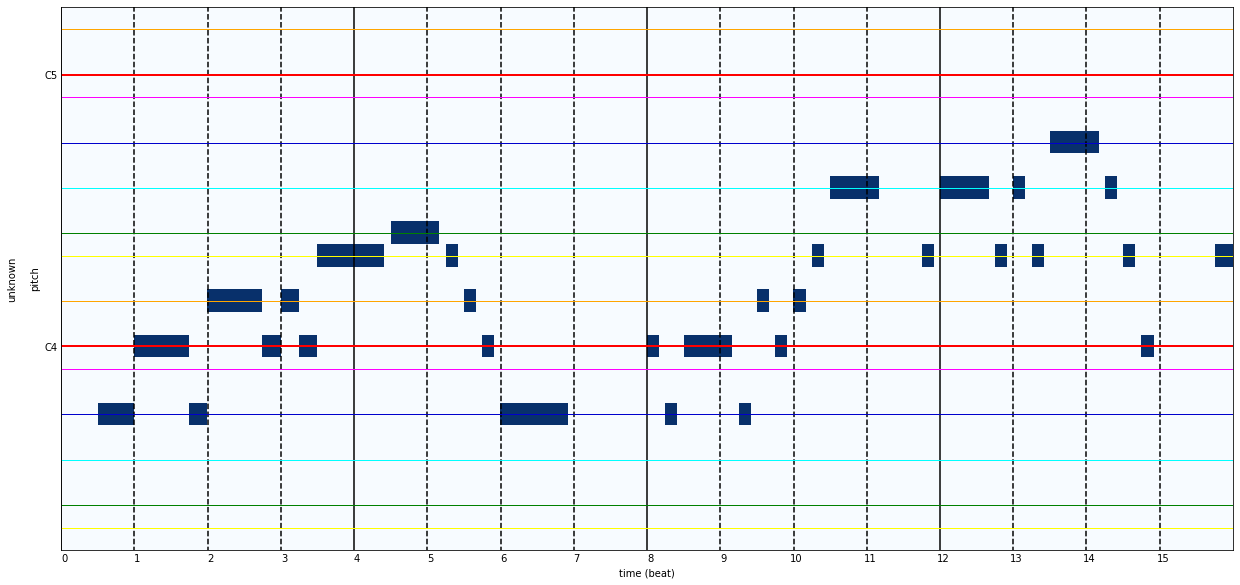

In [28]:
index = 4
ppr, series = get_sample(index=index, get_series=True)

with Timer():
    _, melody, prev, chords = process_midinet_double(series, break_by_error=True)

print("melody shape:", melody.shape)
print("prev shape:", prev.shape)
print("chord shape:", chords.shape)
for chord in chords[:4]:
    print([[1,0,1,0,1,1,0,1,0,1,0,1]])
    print(chord.reshape(4*bars, -1))
    print()

grid_plot(get_track(melody), beat_resolution=12)

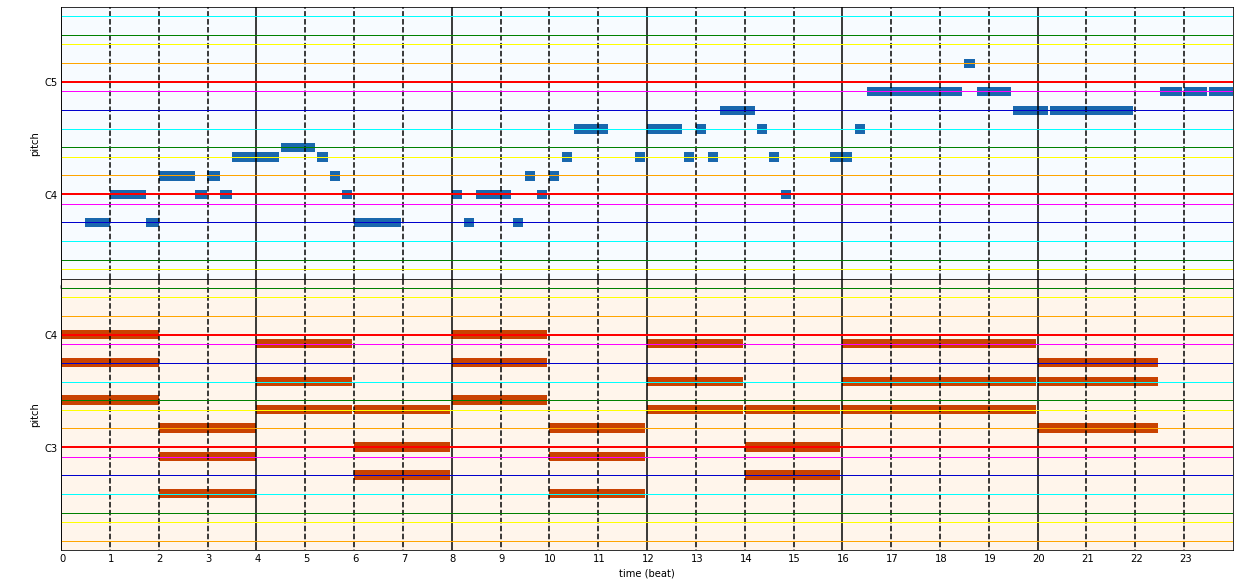

In [25]:
grid_plot(ppr)

## midinet_double, midinet_longデータセットの作成

In [29]:
output_file_path = os.path.join(output_dir, "midinet_long.pkl")

In [30]:
df_mp = pd.read_csv(input_csv)
df_mp = df_mp[df_mp["nokey"] & (df_mp["time_signature"] == "4/4")]
df_mp = df_mp[df_mp["has_melody_track"] & df_mp["has_chord_track"]]
df_mp = df_mp.reset_index()
file_num = df_mp.shape[0]
print("# of midi files to process:", file_num)

# of midi files to process: 16386


### マルチプロセッシング開始

In [31]:
multi_processing = True
process_func = process_midinet_double
dataset = df_mp

In [32]:
if multi_processing:
    pool = Pool()
    with Timer():
        iterator = pool.map(process_func, dataset.iterrows())
else:
    iterator = map(process_func, dataset.iterrows())

melody_list, prev_list, chord_list, error_list, empty_list = [], [], [], [], []

with Timer():
    for path, m, p, c in iterator:
        if m is None or p is None or c is None:
            error_list.append(path)
        elif len(m) == 0 or len(p) == 0 or len(c) == 0:
            empty_list.append(path)
        else:
            melody_list.append(m)
            prev_list.append(p)
            chord_list.append(c)

with Timer():
    melody_stacked, prev_stacked, chord_stacked = [np.vstack(lst) for lst in [melody_list, prev_list, chord_list]]
    data = zip(melody_stacked, prev_stacked, chord_stacked) # zipなのでGeneratorなので消えるので注意

print("Preprocessing Finished!")
print(f"{len(melody_stacked)} bars created")
print(f"{len(empty_list)} songs resulted in empty")
print(f"{len(error_list)} error caused")
print("error file paths")
print(error_list)

Timer: 96.667226
Timer: 0.094898
Timer: 5.100564
Preprocessing Finished!
38756 bars created
1000 songs resulted in empty
0 error caused
error file paths
[]


### 保存と読込

In [33]:
with Timer():
    pickle.dump(data, open(output_file_path, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

Timer: 68.884172


In [34]:
with Timer():
    data = pickle.load(open(output_file_path,'rb'))

Timer: 31.975916


In [35]:
melody, prev, chords = [], [], []
for m, p, c in data:
    melody.append(m)
    prev.append(p)
    chords.append(c)
melody, prev, chords = [np.array(item) for item in [melody, prev, chords]]
print(f"{len(melody)} bars")

38756 bars


melody shape: (38756, 192, 64)
prev shape: (38756, 192, 64)
chord shape: (38756, 192)
[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]
[[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]]

[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]
[[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0

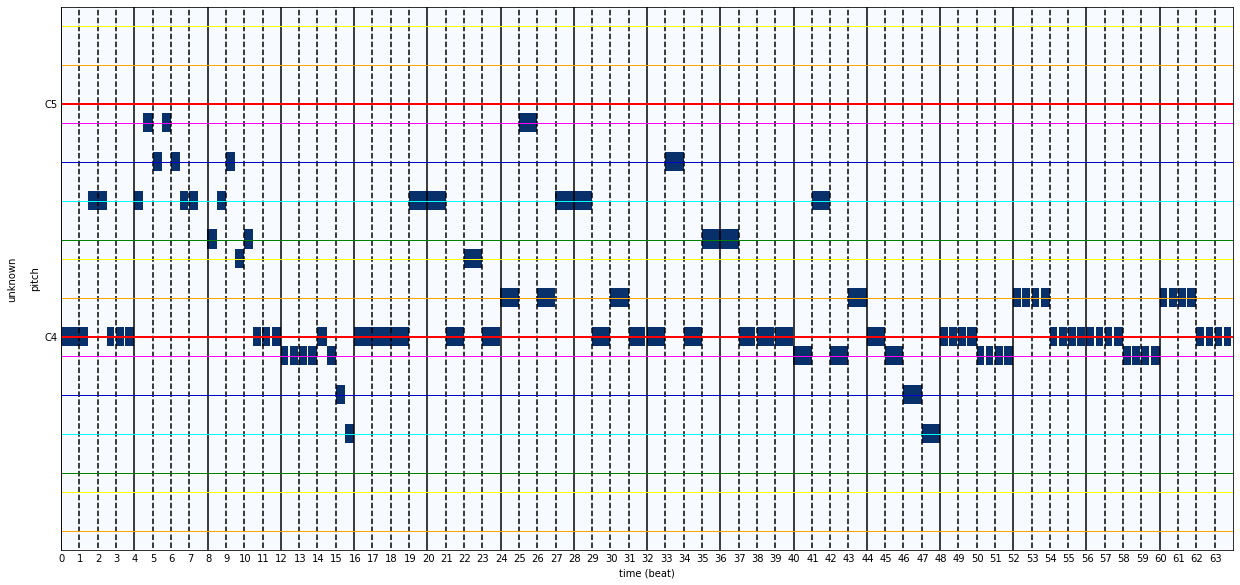

In [38]:
bars = 2
left = 0
right = left+(8 // bars)
print("melody shape:", melody.shape)
print("prev shape:", prev.shape)
print("chord shape:", chords.shape)
for chord in chords[:4]:
    print([[1,0,1,0,1,1,0,1,0,1,0,1]])
    print(chord.reshape(4*bars, -1))
    print()
grid_plot(get_track(melody[left:right]), beat_resolution=12)